# MODELOS NO SUPERVISADOS

Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import os

from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping

import pickle



# Importación de X e y

In [2]:
ruta = "../data/exports"

X_rgb = np.load(os.path.join(ruta, "X_rgb.npy"))

y = np.load(os.path.join(ruta, "y_encoded.npy"), allow_pickle=True)

# Importación para el modelo kmeans
X_flat = np.load(os.path.join(ruta, "X_flat.npy"))

In [3]:
X = X_rgb
X.shape

(4000, 64, 64, 3)

In [4]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(4000, 4))

In [6]:
print(X_flat)
X_flat.shape

[[  0   0   0 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 [107  81  56 ... 166 133 114]
 ...
 [156 140 129 ...  69  54  47]
 [ 30  36  21 ... 109 105 112]
 [  3   3   3 ...   6   6   6]]


(4000, 12288)

# Split en train y test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (3600, 64, 64, 3)
y_train:  (3600, 4)
X_test:  (400, 64, 64, 3)
y_test:  (400, 4)


C:\Users\Administrador\AppData\Local\Temp\ipykernel_24396\388361512.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.imshow(X_train[1], cmap=plt.cm.get_cmap('Greys'));


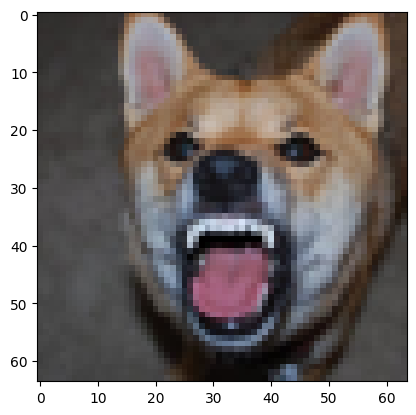

In [56]:
plt.imshow(X_train[1], cmap=plt.cm.get_cmap('Greys'));

## Kmeans

In [ ]:
scaler = StandardScaler()
X_scal = scaler.fit_transform(X_flat)

In [ ]:
pca = PCA(n_components=50, random_state=11)
X_pca = pca.fit_transform(X_scal)

In [ ]:
K = np.arange(2, 11)

scores = []

for cl in K:
    kmeans = KMeans(n_clusters=cl, random_state=11, n_init=10)
    kmeans.fit(X_pca)

    score = silhouette_score(X_pca, kmeans.labels_)
    print(f"Silhouette score de K = {cl}:", score)
    scores.append(score)

print("_" * 50)
best_index = np.argmax(scores)
best_K = K[best_index]
best_score = scores[best_index]

print(f"Mejor K según Silhouette: {best_K}")

Silhouette score de K = 2: 0.14724362512493308
Silhouette score de K = 3: 0.09427163915050094
Silhouette score de K = 4: 0.09064170210372369
Silhouette score de K = 5: 0.08735868904309065
Silhouette score de K = 6: 0.08020027308434899
Silhouette score de K = 7: 0.07016615030061192
Silhouette score de K = 8: 0.0691570674995217
Silhouette score de K = 9: 0.06457688520779575
Silhouette score de K = 10: 0.061766864651634765
__________________________________________________
Mejor K según Silhouette: 2


In [ ]:
kmeans_model = KMeans(n_clusters=2, n_init=10, random_state=11)
pred_kmeans = kmeans_model.fit_predict(X_pca) 

score = silhouette_score(X_pca, pred_kmeans)
print(f"Silhouette score de K=2:", score)

Silhouette score de K=2: 0.14724362512493308


In [108]:
pred_kmeans

array([0, 1, 1, ..., 1, 0, 1], shape=(4000,), dtype=int32)

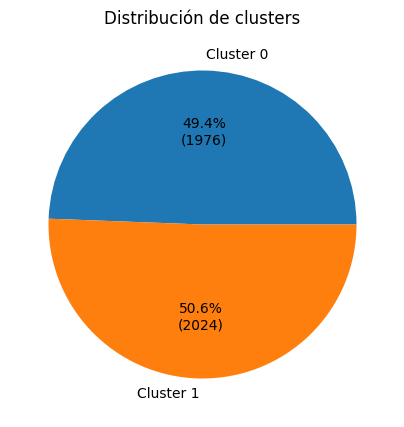

In [ ]:
counts = pd.Series(pred_kmeans).value_counts().sort_index()

plt.figure(figsize=(5,5))
plt.pie(
    counts,
    labels=[f'Cluster {i}' for i in counts.index],
    autopct=lambda pct: f"{pct:.1f}%\n({pct*sum(counts)/100:.0f})"
)
plt.title("Distribución de clusters")
plt.show()

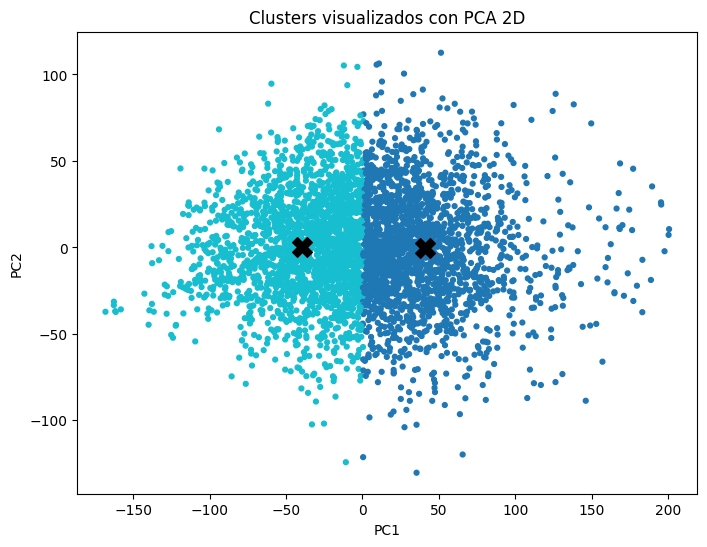

In [ ]:
# PCA SOLO para visualización (desde X_pca)
pca_2d = PCA(n_components=2, random_state=11)
X_2d = pca_2d.fit_transform(X_pca)

# Proyectamos los centroides (MISMO espacio)
centers_2d = pca_2d.transform(kmeans_model.cluster_centers_)

plt.figure(figsize=(8,6))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=pred_kmeans,
    cmap="tab10",
    s=12
)

plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c="black",
    s=200,
    marker="X"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters visualizados con PCA 2D")
plt.show()

### Exportación del modelo a formato pickle 

In [ ]:
pickle.dump(kmeans_model, open("../modelos/modelo_kmeans.pkl", "wb"))

In [ ]:
modelo_kmeans = pickle.load(open("../modelos/modelo_kmeans.pkl", "rb"))
modelo_kmeans

,n_clusters,2
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,11
,copy_x,True
,algorithm,'lloyd'


## Normalización X_train, X_test, y_train, y_test para redes neuronales y convolucionales

In [96]:
np.max(X_train)

np.uint8(255)

In [97]:
np.min(X_train)

np.uint8(0)

In [6]:
# Normalización de X
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [99]:
np.max(X_train)

np.float32(1.0)

In [100]:
np.min(X_train)

np.float32(0.0)

In [101]:
np.mean(X_train)

np.float32(0.433651)

In [7]:
# Normalización de y
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,       
    stratify=y_train,   
    random_state=11
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_val:", X_val.shape)
print("Tamaño X_test:", y_train.shape)
print("Tamaño y_val:", y_val.shape)

Tamaño X_train: (2916, 64, 64, 3)
Tamaño X_val: (324, 64, 64, 3)
Tamaño X_test: (2916, 4)
Tamaño y_val: (324, 4)


In [11]:
np.save('../data/exports/X_train.npy', X_train)
np.save('../data/exports/X_val.npy', X_val)
np.save('../data/exports/y_train.npy', y_train)
np.save('../data/exports/y_val.npy', y_val)

In [65]:
256*256

65536

In [66]:
X_train.shape

(2880, 64, 64, 3)

## Redes neuronales

In [165]:
X_train, y_train = shuffle(X_train, y_train, random_state=11)

In [167]:
model_rn = keras.models.Sequential()

# Capa entrada se aplana de una dimension a una, va a tener 784 neuronas (una para cada pixel) 28x28
# cada pixel es como el feature de un dataset
model_rn.add(keras.layers.Flatten(input_shape=(64, 64, 3)))

# Hidden layer
model_rn.add(keras.layers.Dense(units = 32,
                            activation='relu'))

# Hidden layer
model_rn.add(keras.layers.Dense(units = 16,
                            activation='relu'))

# Capa salida
model_rn.add(keras.layers.Dense(units = 4,
                            activation='softmax'))

In [168]:
model_rn.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = [keras.metrics.CategoricalAccuracy()]
)


In [169]:
# Summary: devuelve la red neuronal que se ha creado
model_rn.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,844 (1.50 MB)

 Trainable params: 393,844 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [170]:
# Entrenamiento
history_rn = model_rn.fit(
    X_train,
    y_train,
    # cuántas muestras se usan para calcular un paso de entrenamiento antes de actualizar los pesos.
    batch_size = 32,
    epochs =50,
    validation_data = (X_val, y_val),
)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.2648 - loss: 1.4875 - val_categorical_accuracy: 0.2500 - val_loss: 1.4215
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3142 - loss: 1.3517 - val_categorical_accuracy: 0.2972 - val_loss: 1.3723
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3364 - loss: 1.3080 - val_categorical_accuracy: 0.3500 - val_loss: 1.2920
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3435 - loss: 1.3042 - val_categorical_accuracy: 0.3444 - val_loss: 1.3024
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3546 - loss: 1.2795 - val_categorical_accuracy: 0.3278 - val_loss: 1.3145
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3639 - loss: 1.2716 - val_categorical_accuracy: 0.3389 - val_loss: 1.2781
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3784 - los

In [171]:
df_history = pd.DataFrame(history_rn.history)
df_history

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.264815,1.487477,0.250000,1.421527
1,0.314198,1.351690,0.297222,1.372262
2,0.336420,1.307962,0.350000,1.292014
3,0.343519,1.304201,0.344444,1.302352
4,0.354630,1.279546,0.327778,1.314547
5,0.363889,1.271637,0.338889,1.278084
6,0.378395,1.262152,0.347222,1.313478
7,0.378395,1.257215,0.352778,1.282862
8,0.390123,1.256834,0.319444,1.405185
9,0.398457,1.248241,0.350000,1.289656


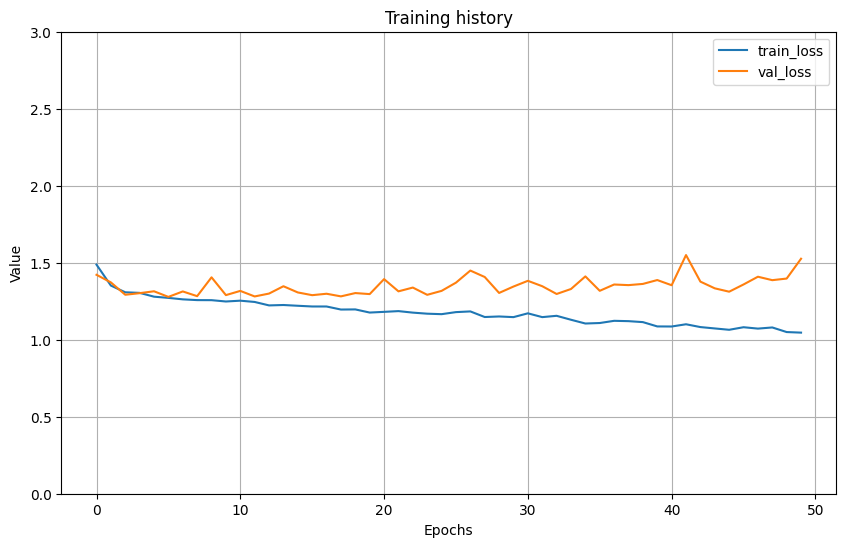

In [172]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 3)  # rango vertical

# Graficamos las métricas
# plt.plot(df_history['categorical_accuracy'], label='train_accuracy')
# plt.plot(df_history['val_categorical_accuracy'], label='val_accuracy')
plt.plot(df_history['loss'], label='train_loss')
plt.plot(df_history['val_loss'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training history')
plt.show()

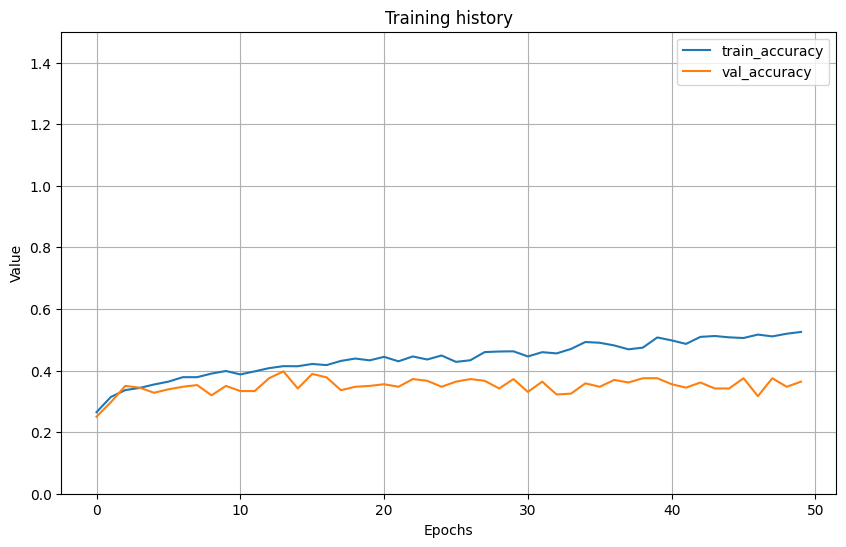

In [173]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)  # rango vertical

# Graficamos las métricas
plt.plot(df_history['categorical_accuracy'], label='train_accuracy')
plt.plot(df_history['val_categorical_accuracy'], label='val_accuracy')
# plt.plot(df_history['loss'], label='train_loss')
# plt.plot(df_history['val_loss'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training history')
plt.show()

In [174]:
results = model_rn.evaluate(X_test, y_test)
results

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3625 - loss: 1.4640


[1.463978886604309, 0.36250001192092896]

In [175]:
y_true_rn = y_test.argmax(axis=1)
y_pred_rn = model_rn.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_true_rn, y_pred_rn)
cm

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[46, 30,  6, 20],
       [19, 62, 15,  5],
       [20, 50, 13, 13],
       [33, 32, 12, 24]])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


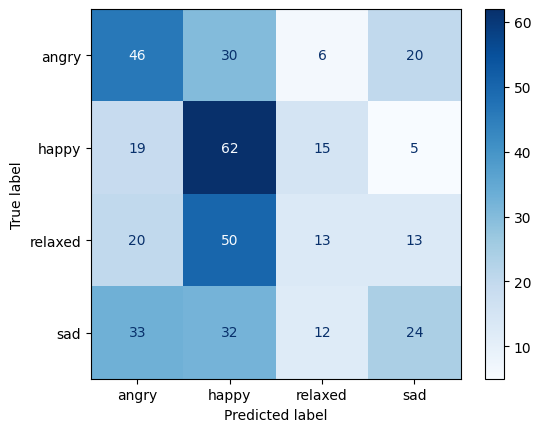

In [176]:
y_pred_probs_rn = model_rn.predict(X_test)
y_pred_classes_rn = np.argmax(y_pred_probs_rn, axis=1)
y_true_classes_rn = np.argmax(y_test, axis=1)

class_names = ["angry", "happy", "relaxed", "sad"]
cm = confusion_matrix(y_true_classes_rn, y_pred_classes_rn)

disp_rn = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_rn.plot(cmap='Blues', values_format='d')

### Exportación del modelo a formato pickle 

In [217]:
model_rn.save("../modelos/modelo_rn.h5")

In [224]:
modelo_redes_n = keras.models.load_model("../modelos/modelo_rn.h5")
modelo_redes_n

<Sequential name=sequential_10, built=True>

In [ ]:
model_rn.save("../modelos/modelo_rn.keras")

In [238]:
modelo_redes_n = keras.models.load_model("../modelos/modelo_rn.keras")
modelo_redes_n.summary()

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,690 (3.00 MB)

 Trainable params: 393,844 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 393,846 (1.50 MB)

# CONCLUSIONES

- El modelo DE red neuronal aprende y mejora el accuracy.

- La validación es inestable, variando entre 37% y 83% lo cual se debe a:

    - Tienes muy pocas imágenes.

    - El modelo no generaliza bien todavía.

- No hay un overfitting extremo, pero sí irregularidad en la validación por el dataset pequeño.

## Redes convolucionales + Redes neuronales 

In [182]:
X_train, y_train = shuffle(X_train, y_train, random_state=11)

In [183]:
layers = [

    # Capas convolucionales
    keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Capas neuronales
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
]

model_conv_neu = keras.Sequential(layers)

model_conv_neu.compile(optimizer = 'adam',
             loss='categorical_crossentropy',
             metrics=[keras.metrics.CategoricalAccuracy()])

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [184]:
model_conv_neu.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,660 (736.95 KB)

 Trainable params: 188,660 (736.95 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
# Entrenamiento
history_conv_neu = model_conv_neu.fit(
    X_train,
    y_train,
    # cuántas muestras se usan para calcular un paso de entrenamiento antes de actualizar los pesos.
    batch_size = 16,
    epochs =30,
    validation_data = (X_val, y_val) # validation_split = 0.1
)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - categorical_accuracy: 0.2377 - loss: 1.3884 - val_categorical_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - categorical_accuracy: 0.2802 - loss: 1.3555 - val_categorical_accuracy: 0.3472 - val_loss: 1.3096
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - categorical_accuracy: 0.3259 - loss: 1.2869 - val_categorical_accuracy: 0.3083 - val_loss: 1.2814
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - categorical_accuracy: 0.3519 - loss: 1.2613 - val_categorical_accuracy: 0.3778 - val_loss: 1.2709
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - categorical_accuracy: 0.3889 - loss: 1.2339 - val_categorical_accuracy: 0.3750 - val_loss: 1.2729
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - categorical_accuracy: 0.4191 - loss: 1.1971 - val_categorical_accuracy: 0.4028 - val_loss: 1.3289
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - categorical_accuracy

In [186]:
df_history_conv_neu = pd.DataFrame(history_conv_neu.history)
df_history_conv_neu

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.237654,1.388414,0.250000,1.386276
1,0.280247,1.355485,0.347222,1.309587
2,0.325926,1.286906,0.308333,1.281370
3,0.351852,1.261266,0.377778,1.270900
4,0.388889,1.233874,0.375000,1.272865
5,0.419136,1.197144,0.402778,1.328944
6,0.453704,1.151220,0.419444,1.283582
7,0.497531,1.083514,0.397222,1.276737
8,0.549074,1.009586,0.377778,1.342315
9,0.618210,0.885609,0.430556,1.624761


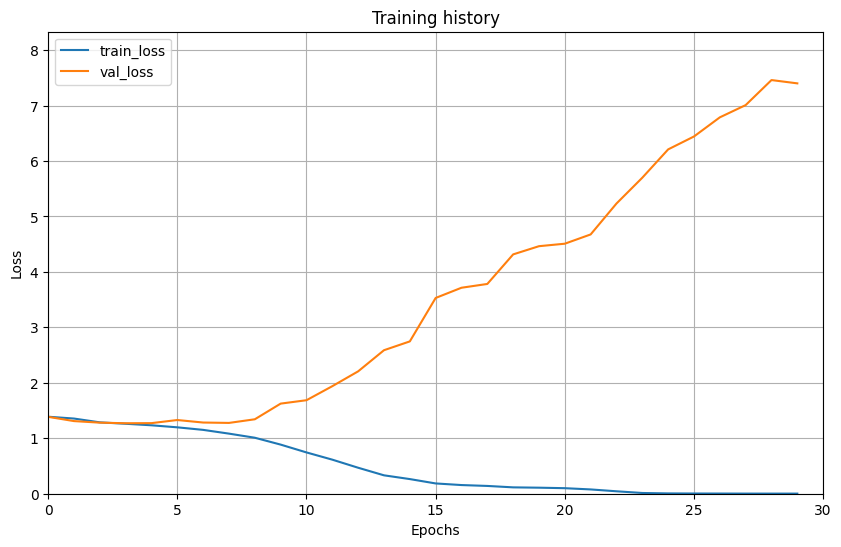

In [187]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)  # rango vertical

plt.plot(df_history_conv_neu['loss'], label='train_loss')
plt.plot(df_history_conv_neu['val_loss'], label='val_loss')

plt.legend()
plt.xlim(0, len(df_history_conv_neu['loss']))  
plt.ylim(0, max(df_history_conv_neu['loss']) * 6)  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

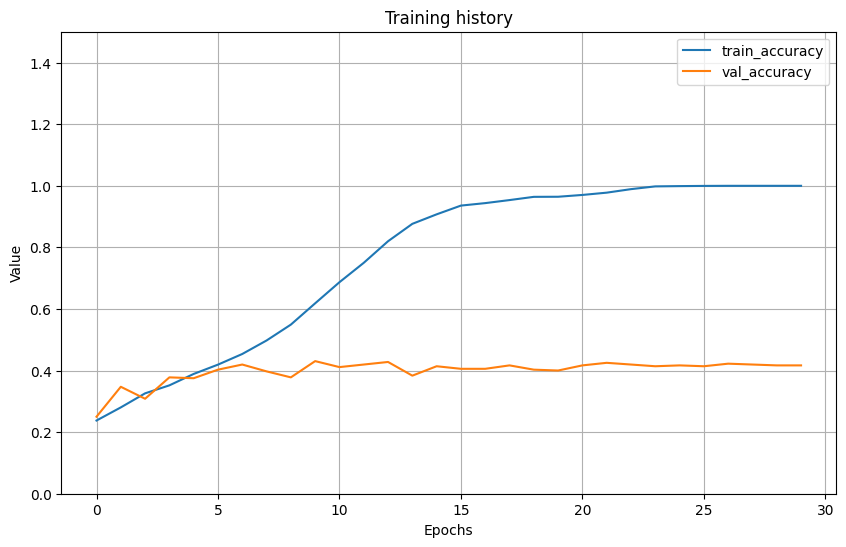

In [188]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)  # rango vertical

# Graficamos las métricas
plt.plot(df_history_conv_neu['categorical_accuracy'], label='train_accuracy')
plt.plot(df_history_conv_neu['val_categorical_accuracy'], label='val_accuracy')
# plt.plot(df_history_conv_neu['loss'], label='train_loss')
# plt.plot(df_history_conv_neu['val_loss'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training history')
plt.show()

In [189]:
mse_test = model_conv_neu.evaluate(X_test, y_test)
print(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.3775 - loss: 6.8448
[6.844815254211426, 0.3774999976158142]


In [191]:
y_true_conv_rn = y_test.argmax(axis=1)
y_pred_conv_rn = model_conv_neu.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_true_conv_rn, y_pred_conv_rn)
cm

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[50, 18, 18, 16],
       [19, 33, 26, 23],
       [14, 35, 28, 19],
       [24, 13, 24, 40]])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


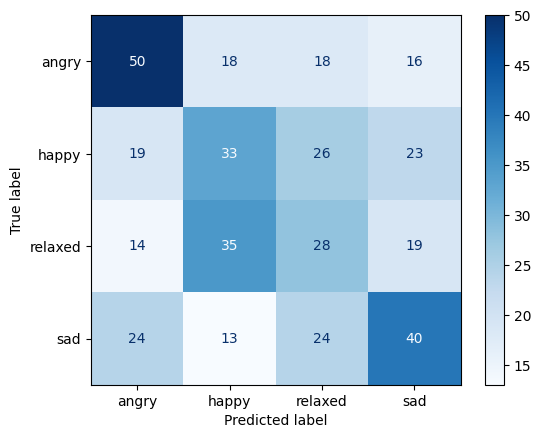

In [192]:
y_pred_probs = model_conv_neu.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_names = ["angry", "happy", "relaxed", "sad"]
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

### Exportación del modelo a formato keras

In [219]:
model_conv_neu.save("../modelos/modelo_conv_rn.h5")

In [225]:
modelo_redes_cv_rn = keras.models.load_model("../modelos/modelo_conv_rn.h5")
modelo_redes_cv_rn

<Sequential name=sequential_11, built=True>

In [230]:
model_conv_neu.save("../modelos/modelo_conv_rn.keras")

In [239]:
modelo_redes_cv_rn = keras.models.load_model("../modelos/modelo_conv_rn.keras")
modelo_redes_cv_rn.summary()

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,322 (1.44 MB)

 Trainable params: 188,660 (736.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 188,662 (736.96 KB)

# CONCLUSIONES

El modelo ha mejorad con respecto a la red neuronal anterior:

- **Validación más estable**
- **Aprendizaje más coherente**

Aún hay margen de mejora porque:

- El dataset sigue siendo pequeño (239 imágenes)
- Se puede usar **data augmentation** o **transfer learning** para estabilizar y subir la accuracy.


## Redes convolucionales + Redes neuronales + Data Augmentation

In [193]:
train_datagen = ImageDataGenerator(
    rescale=1./1,
    rotation_range=10,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    zoom_range=0.1,         
    horizontal_flip=True,   
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator   = val_datagen.flow(X_val, y_val, batch_size=16)

In [194]:
layers_final = [
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
]

model_conv_neu_final = keras.Sequential(layers_final)

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [195]:
model_conv_neu_final.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,436 (1.49 MB)

 Trainable params: 390,436 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
model_conv_neu_final = keras.Sequential(layers_final)
model_conv_neu_final.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [197]:
history_conv_neu_final = model_conv_neu_final.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - categorical_accuracy: 0.2682 - loss: 1.3759 - val_categorical_accuracy: 0.2639 - val_loss: 1.3567
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - categorical_accuracy: 0.3330 - loss: 1.3048 - val_categorical_accuracy: 0.3250 - val_loss: 1.2965
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - categorical_accuracy: 0.3534 - loss: 1.2849 - val_categorical_accuracy: 0.3278 - val_loss: 1.2941
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.3583 - loss: 1.2803 - val_categorical_accuracy: 0.3278 - val_loss: 1.2916
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_accuracy: 0.3657 - loss: 1.2692 - val_categorical_accuracy: 0.3361 - val_loss: 1.3232
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_accuracy: 0.3627 - loss: 1.2613 - val_categorical_accuracy: 0.3167 - val_loss: 1.3382
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.383

In [203]:
df_history_conv_neu_final = pd.DataFrame(history_conv_neu_final.history)
df_history_conv_neu_final

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.268210,1.375948,0.263889,1.356715
1,0.333025,1.304784,0.325000,1.296486
2,0.353395,1.284872,0.327778,1.294051
3,0.358333,1.280305,0.327778,1.291606
4,0.365741,1.269185,0.336111,1.323243
5,0.362654,1.261294,0.316667,1.338240
6,0.383333,1.253918,0.377778,1.276888
7,0.371605,1.246235,0.358333,1.313268
8,0.381481,1.240395,0.386111,1.308218
9,0.390741,1.234434,0.363889,1.348507


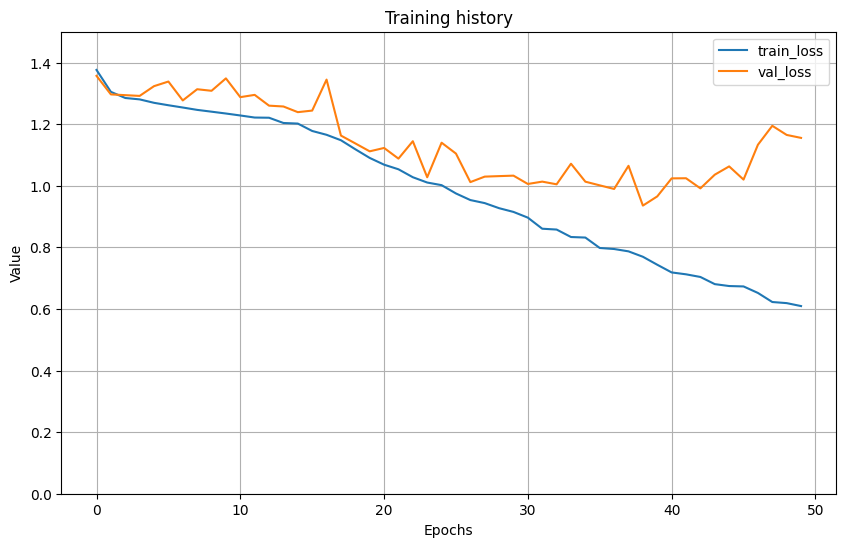

In [204]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)  # rango vertical

# Graficamos las métricas
# plt.plot(df_history_conv_neu['categorical_accuracy'], label='train_accuracy')
# plt.plot(df_history_conv_neu['val_categorical_accuracy'], label='val_accuracy')
plt.plot(df_history_conv_neu_final['loss'], label='train_loss')
plt.plot(df_history_conv_neu_final['val_loss'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training history')
plt.show()

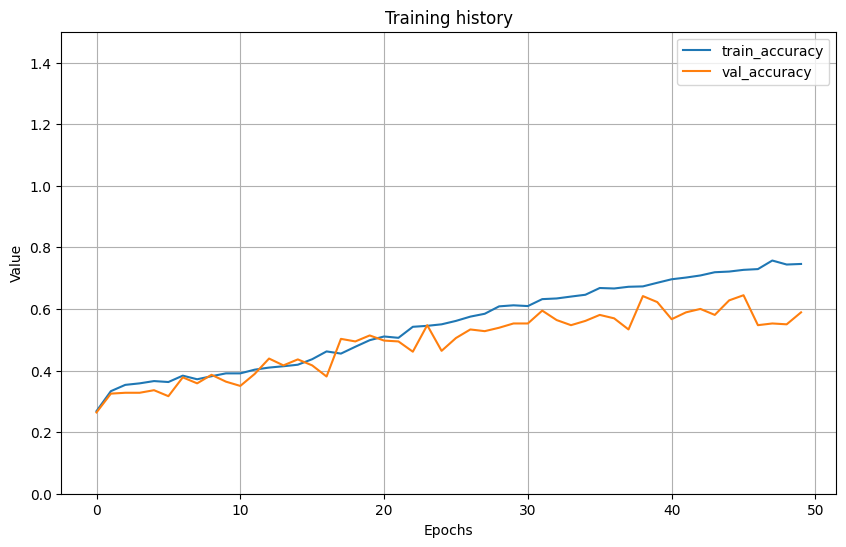

In [205]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)  # rango vertical

# Graficamos las métricas
plt.plot(df_history_conv_neu_final['categorical_accuracy'], label='train_accuracy')
plt.plot(df_history_conv_neu_final['val_categorical_accuracy'], label='val_accuracy')
# plt.plot(df_history_conv_neu['loss'], label='train_loss')
# plt.plot(df_history_conv_neu['val_loss'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training history')
plt.show()

In [206]:
mse_test = model_conv_neu_final.evaluate(X_test, y_test)
print(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.5875 - loss: 1.1118
[1.111832857131958, 0.5874999761581421]


C:\Users\Administrador\AppData\Local\Temp\ipykernel_24396\1990880056.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.imshow(X_test[1].reshape(64,64,3), cmap=plt.cm.get_cmap('Greys'));


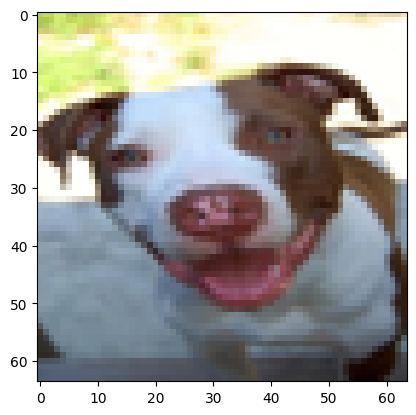

In [207]:
plt.imshow(X_test[1].reshape(64,64,3), cmap=plt.cm.get_cmap('Greys'));

In [208]:
y_true_conv_rn_final = y_test.argmax(axis=1)
y_pred_conv_rn_final = model_conv_neu_final.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_true_conv_rn_final, y_pred_conv_rn_final)
cm

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[70, 12,  7, 13],
       [30, 59,  6,  6],
       [21, 15, 30, 30],
       [15,  3,  7, 76]])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


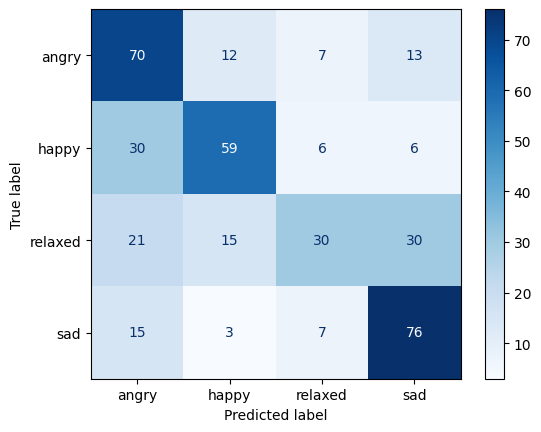

In [209]:
y_pred_probs = model_conv_neu_final.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_names = ["angry", "happy", "relaxed", "sad"]
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

# Exportación del modelo

In [226]:
model_conv_neu_final.save("../modelos/modelo_conv_rn_final.h5")

In [227]:
modelo_redes_cv_rn_final = keras.models.load_model("../modelos/modelo_conv_rn_final.h5")
modelo_redes_cv_rn_final


<Sequential name=sequential_13, built=True>

In [232]:
model_conv_neu_final.save("../modelos/modelo_conv_rn_final.keras")

In [237]:
modelo_redes_cv_rn_final = keras.models.load_model("../modelos/modelo_conv_rn_final.keras")
modelo_redes_cv_rn_final.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,874 (2.98 MB)

 Trainable params: 390,436 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 390,438 (1.49 MB)